In [1]:
# Import necessary libraries
import os, pickle, librosa
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
from tqdm import tqdm

## Extracting Dataset

In [3]:
# Listing all subject folders
dataset = list()
sub_list = os.listdir('dataset')
motions = ['OH', 'CH', 'EX', 'FL', 'GR', 'IN', 'SU', 'PR', 'RT']
channels = ['ch1', 'ch2', 'ch3', 'ch4', 'ch5', 'ch6', 'ch7', 'ch8']

# Iterate all subject folders to extract data
for sub in tqdm(sub_list):
    sub_data = os.listdir(f'dataset/{sub}')

    # Iterate all subject data to extract
    for sub_datum in sub_data:
        # Read Matlab file
        record = sp.io.loadmat(f'./dataset/{sub}/{sub_datum}')
        record = record['U']            

        # Extract session day and number
        session = record['session'][0,0].tolist()[0]
        day, session_n = session.split('S')
        if day[1] == '0':
            day = 'D' + day[-1]
        session_n = 'S' + session_n

        # Fix input error
        if sub_datum == 'Sub04_sessionD6S1_MyoEMG.mat':
            session_n = 'S1'

        # Extract session EMG
        for motion in motions:
            emg = record[motion][0,0]
            df = pd.DataFrame(emg, columns=channels)

            for i in range(0, 10):
                repetition = i + 1
                motion_n = int(len(df) / 10)
                start_idx  = i * motion_n
                sub_df = df[start_idx:start_idx + motion_n]

                # Append to dataset list
                dataset.append((sub, day, session_n, motion, repetition, sub_df))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:05<00:00,  1.30it/s]


In [4]:
len(dataset)

18900

In [5]:
len([data for data in dataset if (data[0] == 'sub04') & (data[1] == 'D6') & (data[2] == 'S1')])

90

In [6]:
len([row for row in dataset if (row[0] == 'sub04') & (row[1] == 'D6') & (row[2] == 'S2')])

90

In [7]:
# Save dataset into pickle file
file = open('./emg_data.pkl', 'wb')
pickle.dump(dataset, file)
file.close()

In [2]:
file = open('./emg_data.pkl', 'rb')
dataset = pickle.load(file)
file.close()

## Data Exploration

In [4]:
dataset[0]

('sub03',
 'D3',
 'S1',
 'OH',
 1,
           ch1       ch2       ch3       ch4       ch5       ch6       ch7  \
 0    0.414062  0.601562 -0.203125 -0.210938 -0.101562 -0.046875  0.257812   
 1    0.320312 -0.140625  0.070312  0.062500 -0.015625  0.062500 -0.296875   
 2   -0.476562 -0.140625 -0.593750  0.132812  0.039062  0.109375  0.015625   
 3   -0.039062 -0.492188 -0.679688 -0.031250  0.031250  0.062500 -0.101562   
 4   -0.007812 -0.093750  0.562500 -0.023438 -0.070312 -0.437500 -0.382812   
 ..        ...       ...       ...       ...       ...       ...       ...   
 795  0.054688 -0.101562  0.023438  0.000000  0.000000  0.000000 -0.015625   
 796 -0.093750 -0.046875 -0.054688 -0.023438 -0.007812 -0.023438  0.187500   
 797  0.046875 -0.054688  0.046875  0.039062  0.031250 -0.015625  0.250000   
 798  0.078125 -0.039062  0.046875  0.000000  0.000000 -0.023438 -0.031250   
 799  0.031250  0.117188  0.062500 -0.007812 -0.023438 -0.070312 -0.226562   
 
           ch8  
 0   -0.21

In [5]:
# Set up sample frequency and the time axis
fs = 200
# sample_n = len(dataset[0][4])
# ts = np.linspace(0, sample_n * (1/fs), sample_n)

### Exploring the EMG among Different Channels and Motions

In [9]:
sub1d1s1 = [data for data in dataset if (data[0] == 'sub01') & (data[1] == 'D1') & (data[2] == 'S1') & (data[4] == 1)]

In [20]:
sub1d1s1_df = pd.concat([df[:fs*4].assign(motion=motion) for sub, day, sess, motion, rep, df in sub1d1s1])

In [21]:
sub1d1s1_melt = sub1d1s1_df.melt(id_vars=['motion'], var_name='channel', value_name='value', ignore_index=False)
sub1d1s1_melt = sub1d1s1_melt.reset_index().rename(columns={'index': 'time'})

In [22]:
sub1d1s1_mini = sub1d1s1_melt[~sub1d1s1_melt['motion'].isin(['GR', 'IN'])]

In [23]:
sub1d1s1_melt

,time,motion,channel,value
0,0,OH,ch1,-0.007812
1,1,OH,ch1,-0.007812
2,2,OH,ch1,-0.023438
3,3,OH,ch1,0.031250
4,4,OH,ch1,0.000000
...,...,...,...,...
57595,795,RT,ch8,0.000000
57596,796,RT,ch8,0.000000
57597,797,RT,ch8,0.000000
57598,798,RT,ch8,-0.015625


In [172]:
%matplotlib inline

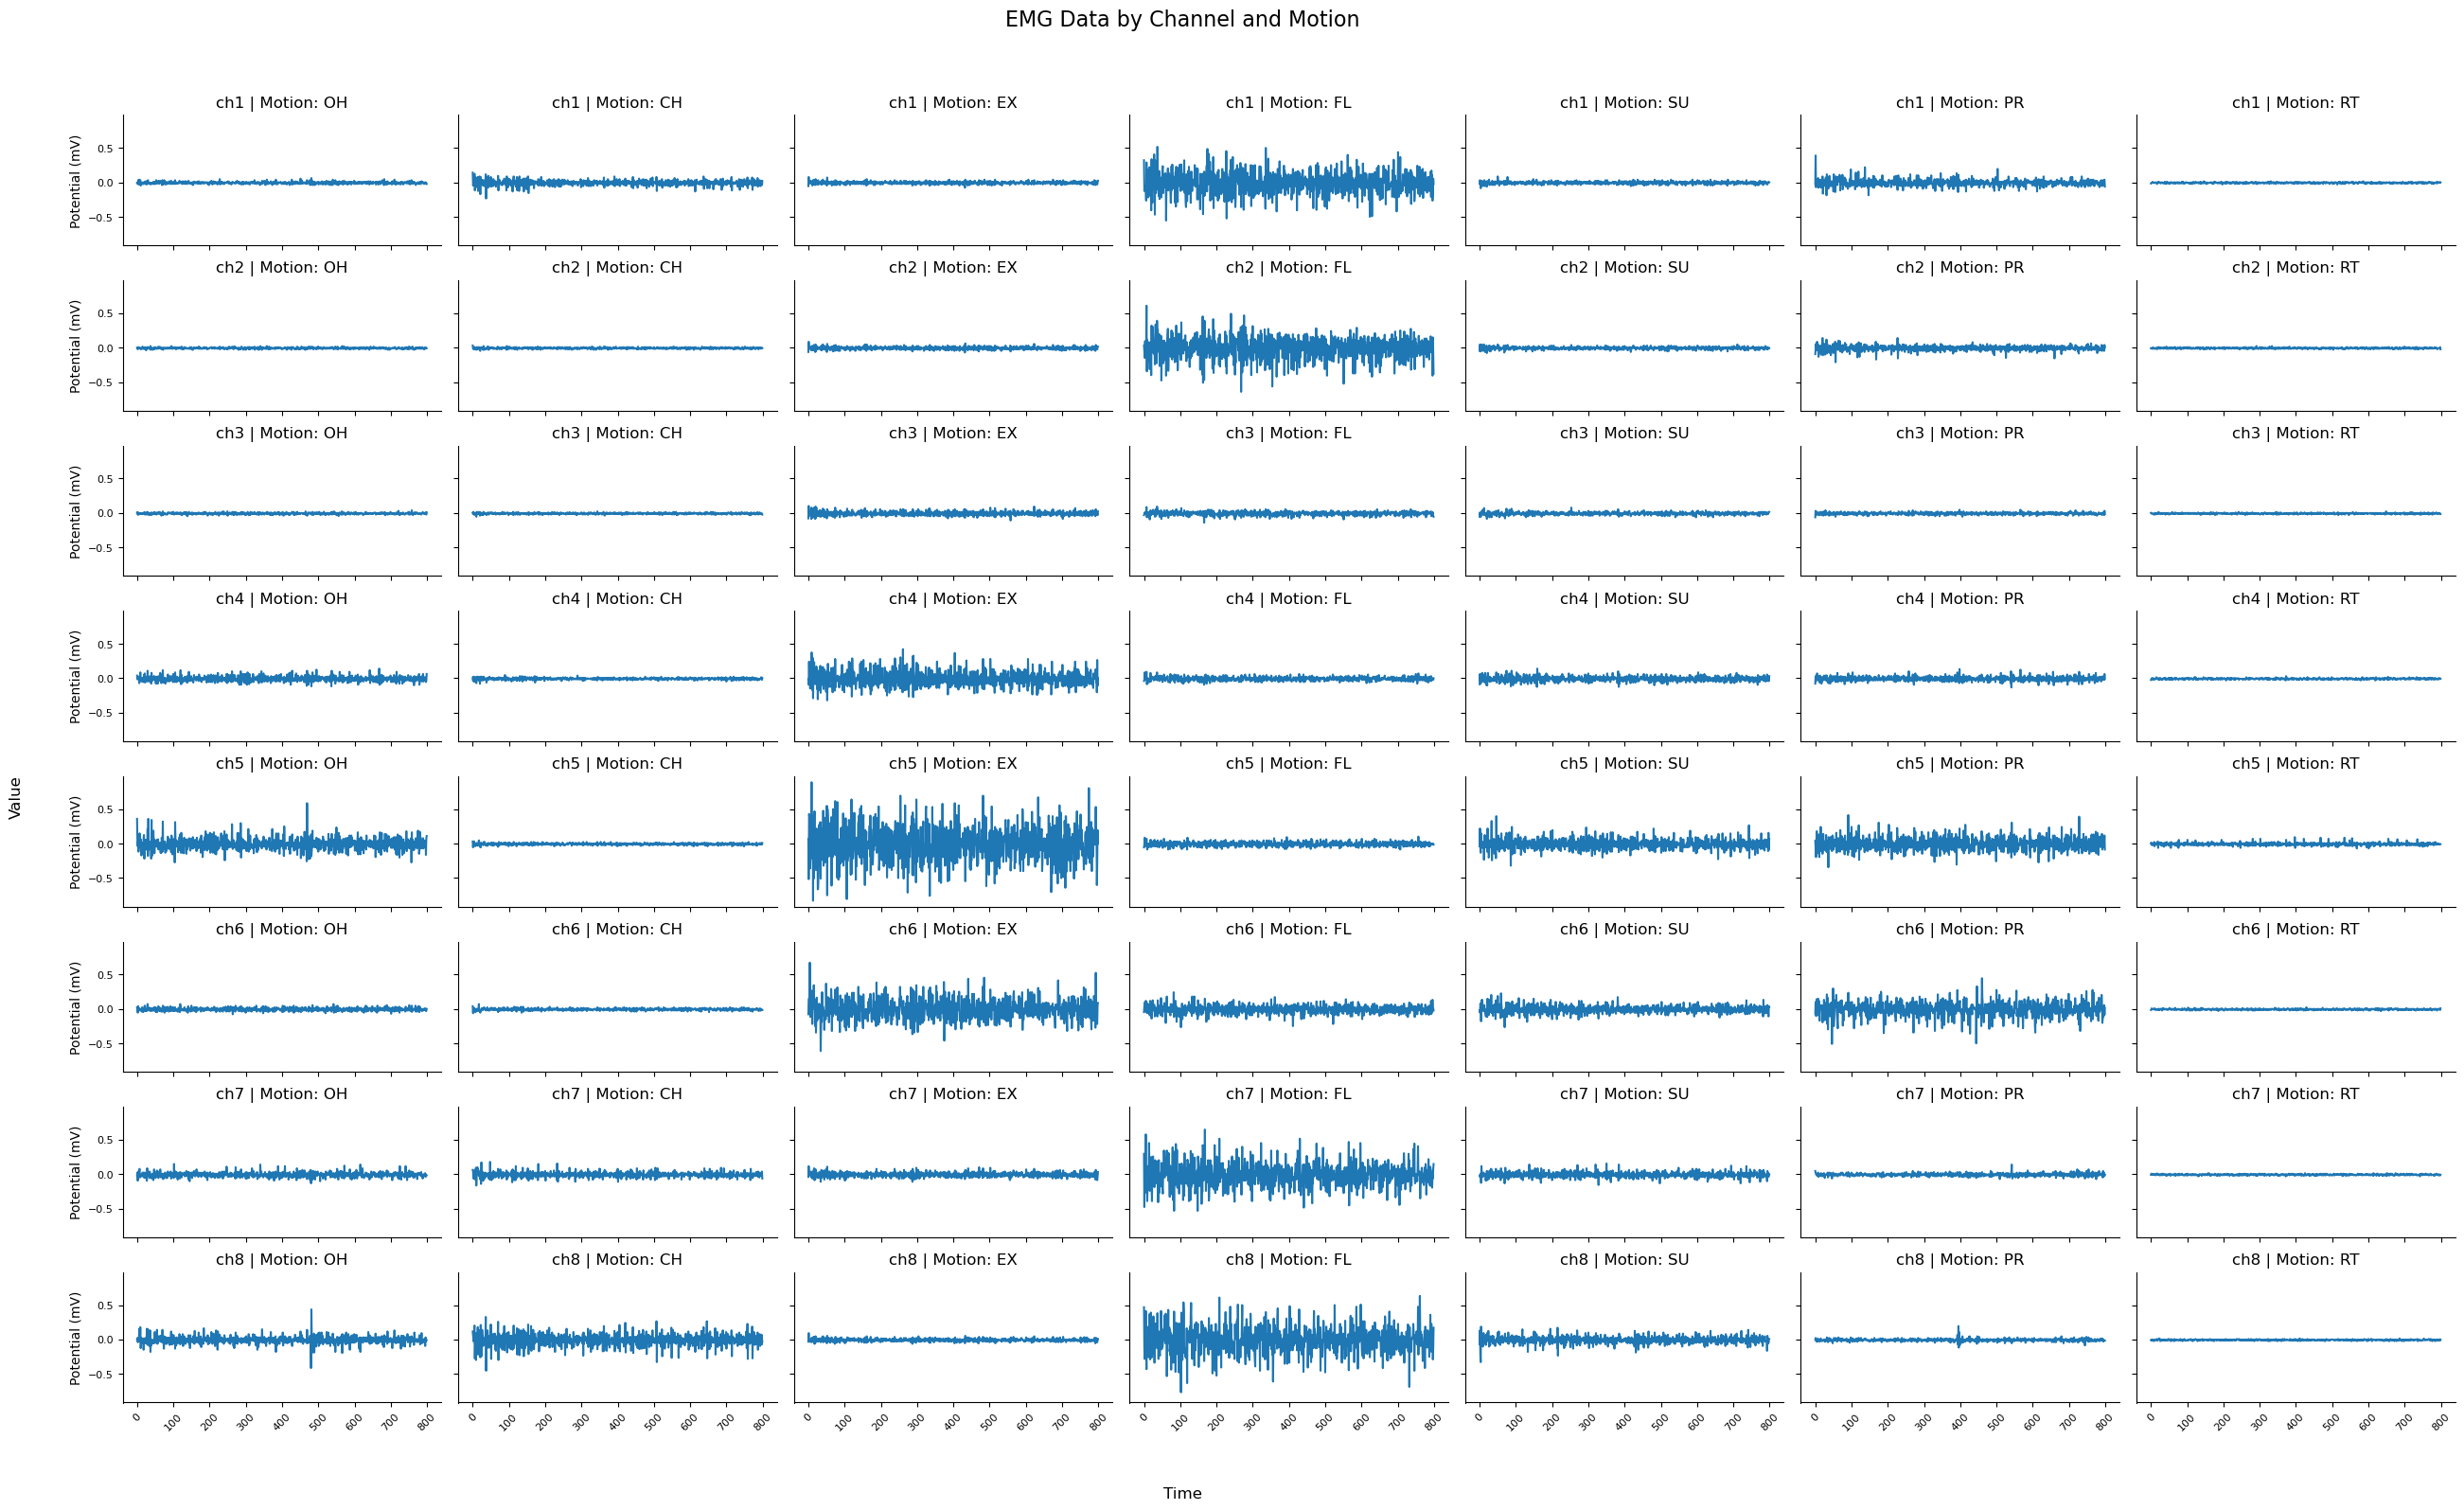

In [174]:
# Create the FacetGrid with corrected layout
g = sns.FacetGrid(sub1d1s1_mini, row='channel', col='motion', 
                  height=2, aspect=2)

# Map the lineplot to each facet
g.map(sns.lineplot, 'time', 'value')

# Customize the subplot titles and labels
g.set_titles(col_template="Motion: {col_name}", row_template="{row_name}", size=12)
g.set_axis_labels("Time (ms)", "Potential (mV)", fontsize=10)

# Rotate x-axis labels and adjust tick parameters
for ax in g.axes.flat:
    ax.tick_params(axis='x', rotation=45, labelsize=8)
    ax.tick_params(axis='y', labelsize=8)
    ax.set_xlabel('')  # Remove x-label from individual subplots

# Add a main title
plt.suptitle("EMG Data by Channel and Motion", fontsize=16, y=1.02)

# Add common x and y labels
g.fig.text(0.5, 0.04, 'Time', ha='center', va='center', fontsize=12)
g.fig.text(0.06, 0.5, 'Value', ha='center', va='center', rotation='vertical', fontsize=12)

# Adjust the layout
g.tight_layout()
plt.subplots_adjust(top=0.95, bottom=0.1, left=0.1, right=0.98)

# Display the plot
plt.show();

In [28]:
sub1d1s1_oh = sub1d1s1_mini[sub1d1s1_mini.motion == 'OH']

In [44]:
sub1d1s1_oh.channel = sub1d1s1_oh.channel.apply(lambda x: x[2:])

/var/folders/fg/wwsz02rn0qn31sz3qslnnjm80000gn/T/ipykernel_60546/1440183005.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub1d1s1_oh.channel = sub1d1s1_oh.channel.apply(lambda x: x[2:])


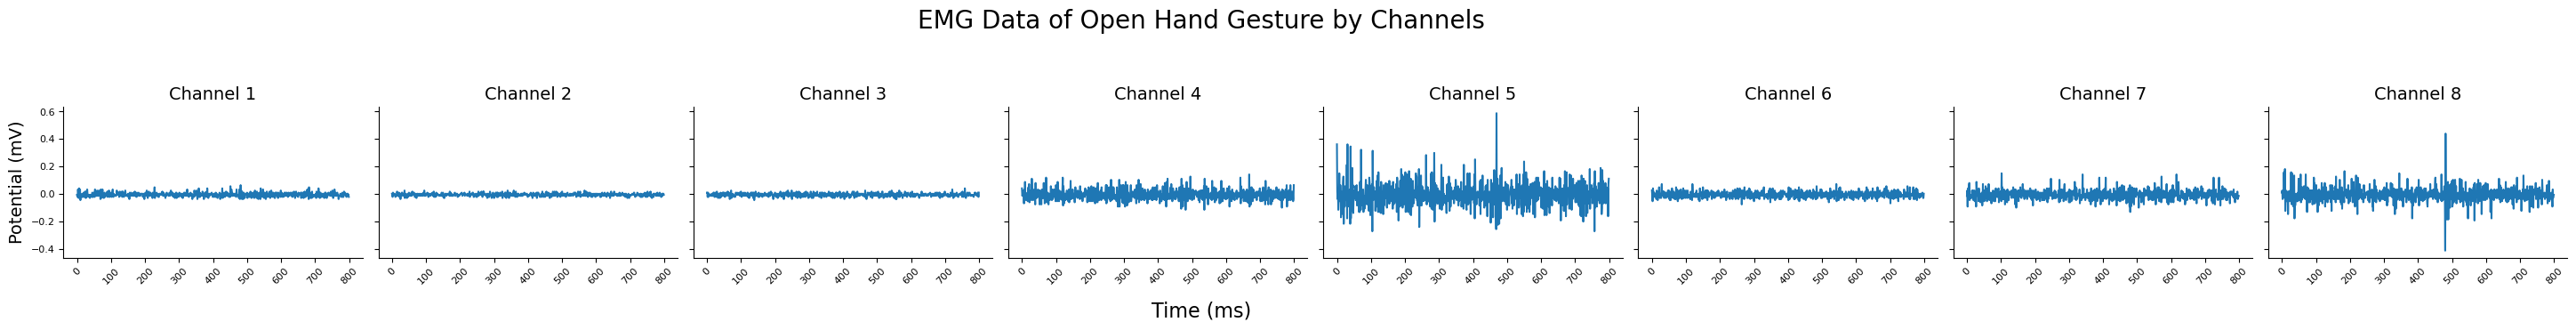

In [50]:
# Create the FacetGrid with corrected layout
g = sns.FacetGrid(sub1d1s1_oh, row='motion', col='channel', 
                  height=2, aspect=2)

# Map the lineplot to each facet
g.map(sns.lineplot, 'time', 'value')

# Customize the subplot titles and labels
g.set_titles(template="Channel {col_name}", size=14)
g.set_axis_labels("Time (ms)", "Potential (mV)", fontsize=14)

# Rotate x-axis labels and adjust tick parameters
for ax in g.axes.flat:
    ax.tick_params(axis='x', rotation=45, labelsize=8)
    ax.tick_params(axis='y', labelsize=8)
    ax.set_xlabel('')  # Remove x-label from individual subplots

# Add a main title
plt.suptitle("EMG Data of Open Hand Gesture by Channels", fontsize=20, y=1.5)

# Add common x and y labels
g.fig.text(0.5, -0.2, 'Time (ms)', ha='center', va='center', fontsize=16)
# g.fig.text(0.06, 0.5, 'Value (mV)', ha='center', va='center', rotation='vertical', fontsize=12)

# Adjust the layout
g.tight_layout()
plt.subplots_adjust(top=0.95, bottom=0.1, left=0.1, right=0.98)

# Display the plot
plt.show();

In [16]:
data_min = [data for data in dataset if (data[0] == 'sub01') & (data[2] == 'S1') & (data[3] == 'OH') & (data[4] == 1)]

In [51]:
df_min = pd.concat([df[:fs*4].assign(day=day) for sub, day, sess, motion, rep, df in data_min])

In [64]:
del df_min['my_index']
del df_min['day_int']

In [53]:
df_min['my_index'] = df_min.index
df_min['day_int'] = df_min.day.apply(lambda x: int(x[1:]))

In [56]:
df_min = df_min.sort_values(['day_int', 'my_index'])

In [65]:
dfmin_melt = df_min.melt(id_vars=['day'], var_name='channel', value_name='value', ignore_index=False)
dfmin_melt = dfmin_melt.reset_index().rename(columns={'index': 'time'})

In [66]:
dfmin_melt

,time,day,channel,value
0,0,D1,ch1,-0.007812
1,1,D1,ch1,-0.007812
2,2,D1,ch1,-0.023438
3,3,D1,ch1,0.031250
4,4,D1,ch1,0.000000
...,...,...,...,...
95995,795,D15,ch8,-0.046875
95996,796,D15,ch8,0.015625
95997,797,D15,ch8,-0.023438
95998,798,D15,ch8,-0.046875


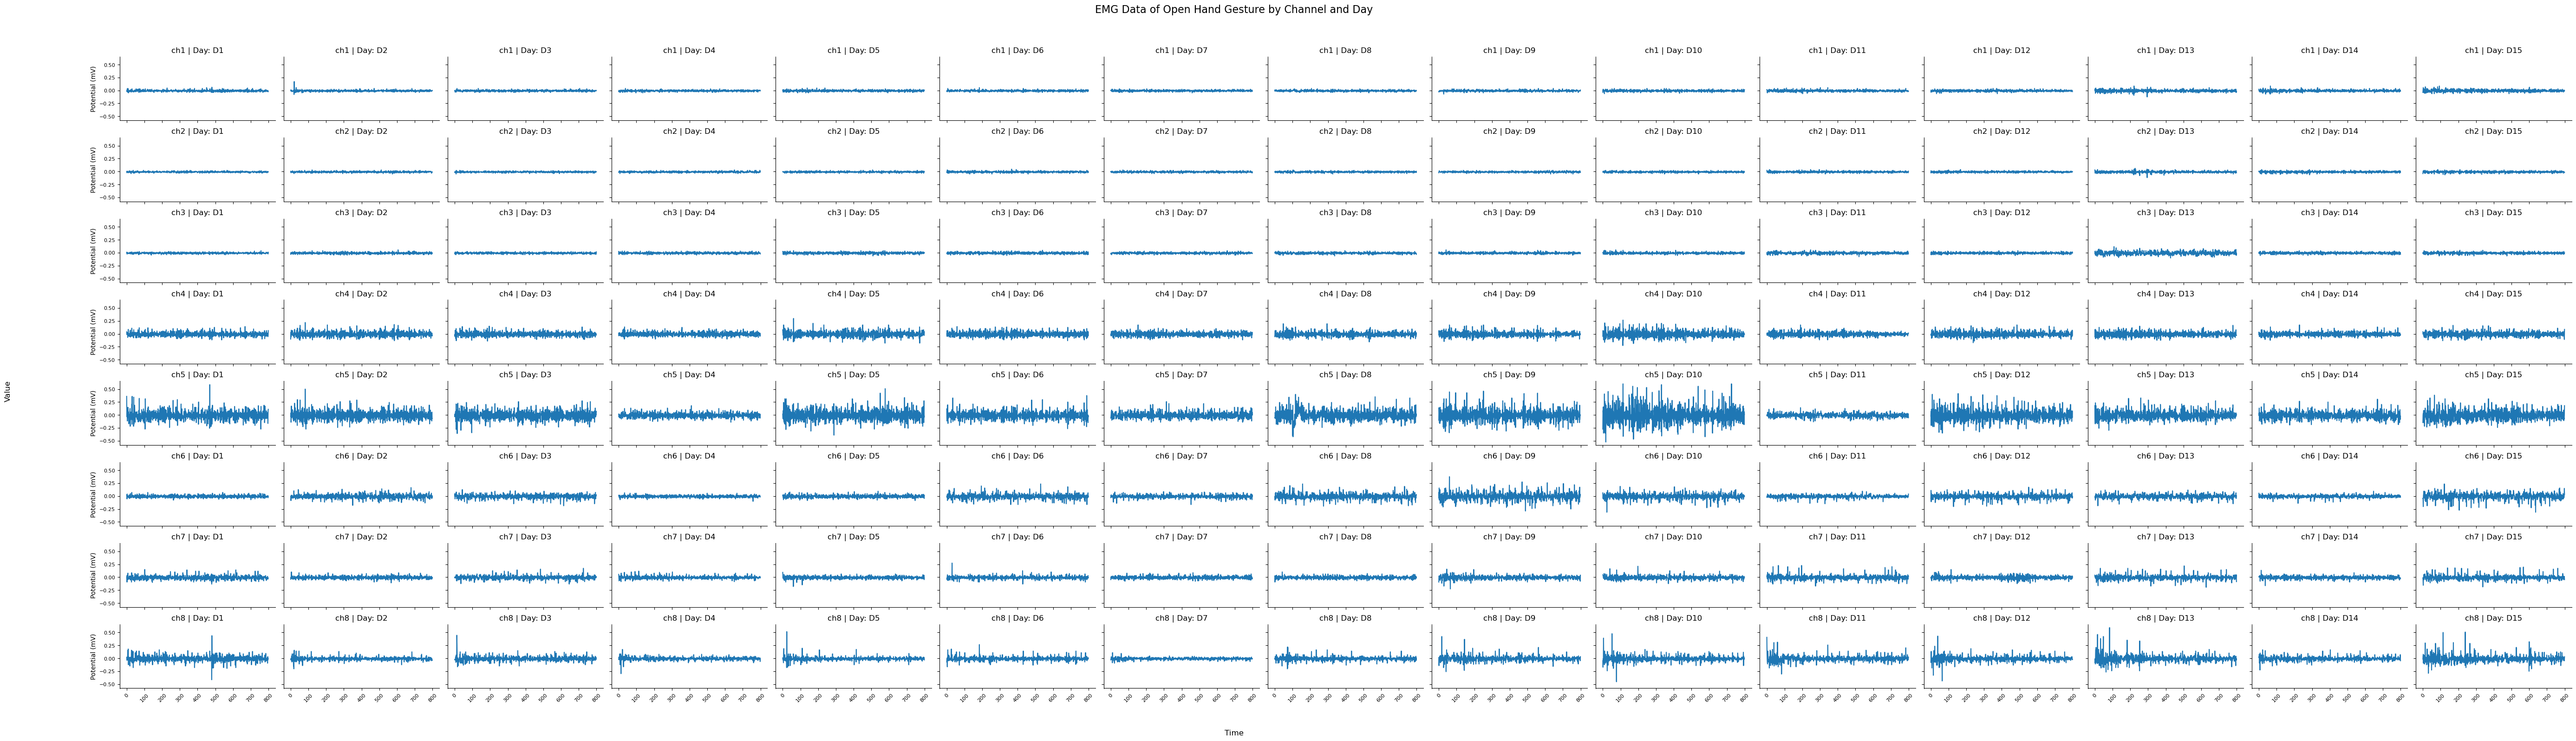

In [68]:
# Create the FacetGrid with corrected layout
g = sns.FacetGrid(dfmin_melt, row='channel', col='day', 
                  height=2, aspect=2)

# Map the lineplot to each facet
g.map(sns.lineplot, 'time', 'value')

# Customize the subplot titles and labels
g.set_titles(col_template="Day: {col_name}", row_template="{row_name}", size=12)
g.set_axis_labels("Time (ms)", "Potential (mV)", fontsize=10)

# Rotate x-axis labels and adjust tick parameters
for ax in g.axes.flat:
    ax.tick_params(axis='x', rotation=45, labelsize=8)
    ax.tick_params(axis='y', labelsize=8)
    ax.set_xlabel('')  # Remove x-label from individual subplots

# Add a main title
plt.suptitle("EMG Data of Open Hand Gesture by Channel and Day", fontsize=16, y=1.02)

# Add common x and y labels
g.fig.text(0.5, 0.04, 'Time', ha='center', va='center', fontsize=12)
g.fig.text(0.06, 0.5, 'Value', ha='center', va='center', rotation='vertical', fontsize=12)

# Adjust the layout
g.tight_layout()
plt.subplots_adjust(top=0.95, bottom=0.1, left=0.1, right=0.98)

# Display the plot
plt.show();

In [31]:
ch1[:200]

0      0.414062
1      0.320312
2     -0.476562
3     -0.039062
4     -0.007812
         ...   
195    0.164062
196   -0.187500
197    0.320312
198    0.093750
199   -0.132812
Name: ch1, Length: 200, dtype: float64

In [47]:
mel_spec = librosa.feature.melspectrogram(y=ch1[:40].to_numpy(), sr=fs, n_fft=128, hop_length=8, fmax=100)

In [48]:
lms = librosa.power_to_db(mel_spec)

In [49]:
lms.shape

(128, 6)

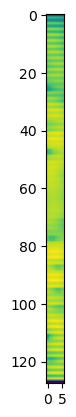

In [50]:
plt.imshow(lms)

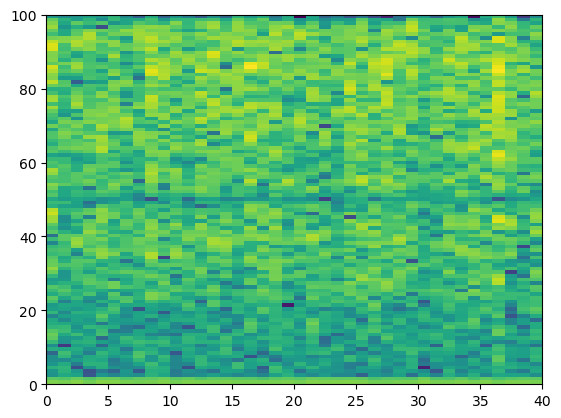

In [59]:
spec, freq, _, _ = plt.specgram(ch1, Fs=fs, NFFT=fs, noverlap=0)

In [60]:
freqs = np.fft.rfftfreq(len(ch1), 1/fs)
fft = np.fft.rfft(ch1)

(0.0, 20.0)

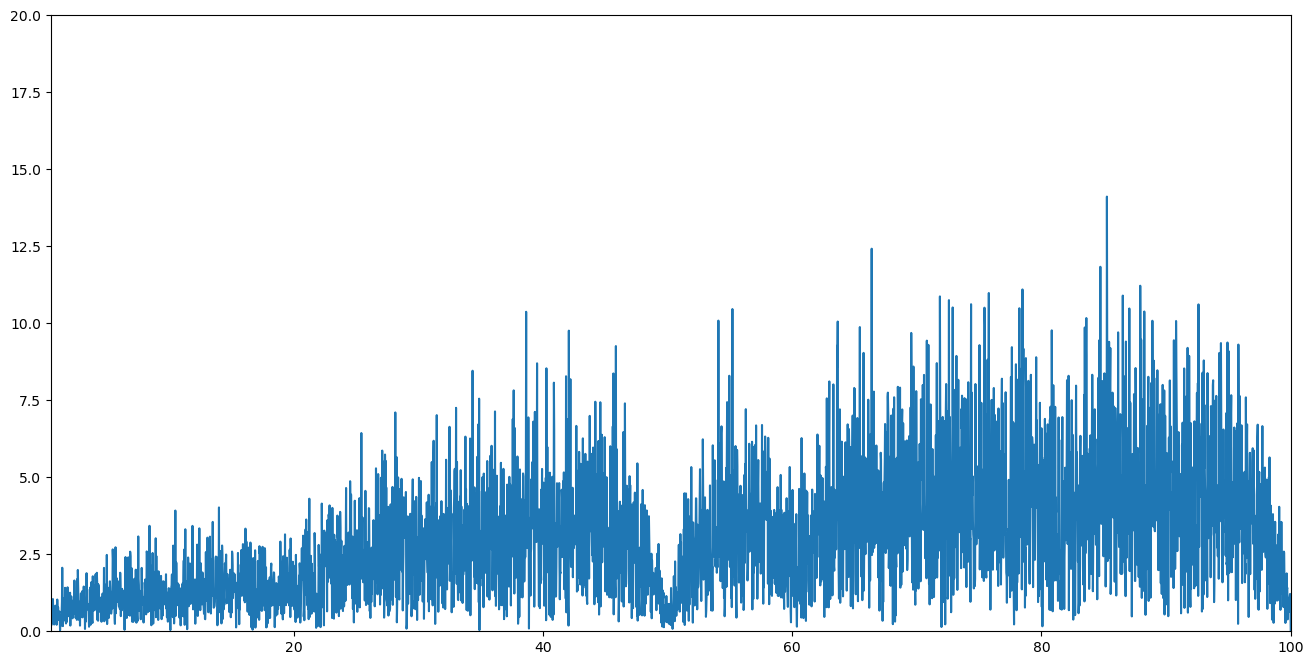

In [69]:
plt.figure(figsize=(16,8))
plt.plot(freqs, np.abs(fft))
plt.xlim(0.5, 100)
plt.ylim(0, 20)

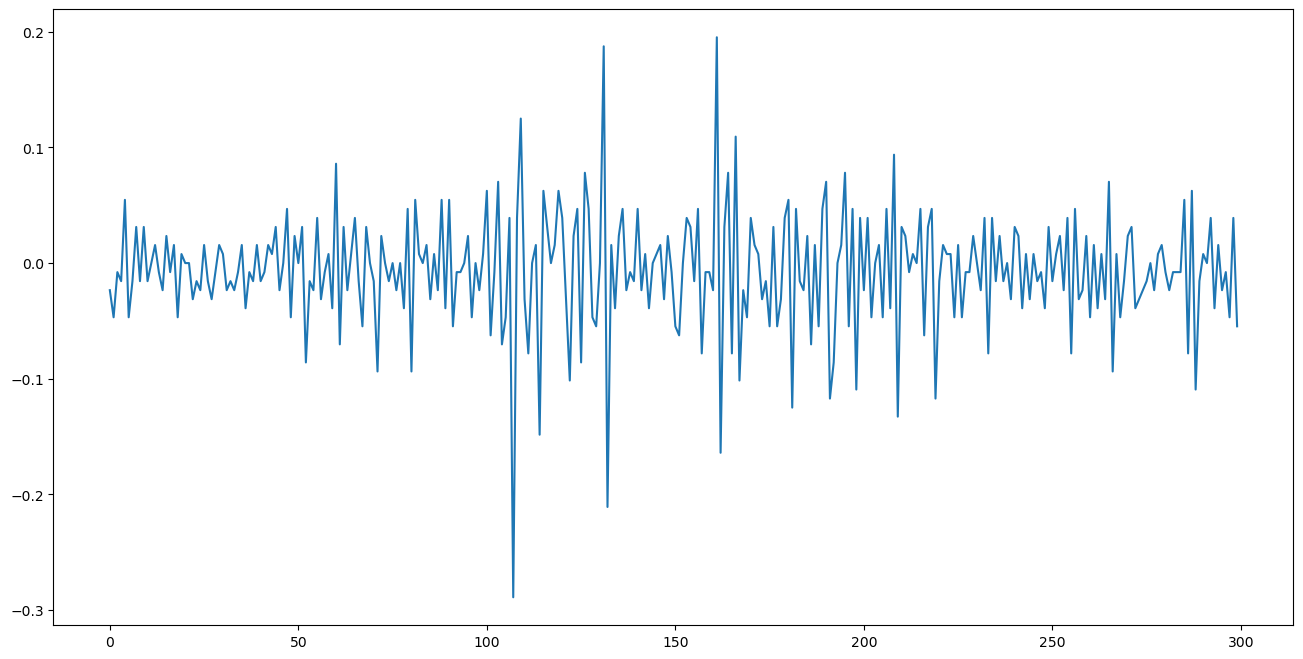

In [72]:
plt.figure(figsize=(16,8))
plt.plot(ch1[1500:1800])